### Image enhancement using Tensorflow

This is a Jupyter Notebook. When you execute code within the notebook, the results appear beneath the code. To execute a code chunk, place your cursor on the cell and press Shift+Enter.

Those who have worked on computer vision problems might already know that the higher the resolution of the input image, the easier it is to identify key features. But you may end up having a low-resolution picture to process.
Sometimes you might have some old photos of your loved ones that you want to display or to take a print, but are low resolution.
Image enhancement is adjusting digital images to make results more suitable for display or further image analysis. For example, you can sharpen, remove noise, or brighten an image, making it easier to identify key features.

Today we will try to enhance a low-resolution image with the help of Tensorflow and Enhanced Super Resolution Generative Adversarial Network(ESRGAN)(by Xintao Wang et.al.) ([Paper](https://arxiv.org/pdf/1809.00219.pdf)/[Code](https://github.com/captain-pool/GSOC/)).

### Prepare environment

1. Download and install Anaconda or the smaller Miniconda.

2. On Windows open the Start menu and open an Anaconda Command Prompt. On macOS or Linux open a terminal window. Use the default bash shell on macOS or Linux.

3. Choose a name for your TensorFlow environment, such as “tf”.

4. To install the current release of CPU-only TensorFlow, recommended for beginners:

In [ ]:
!conda create -n tf tensorflow
!conda activate tf

Or, to install the current release of GPU TensorFlow on Linux or Windows:

In [ ]:
!conda create -n tf-gpu tensorflow-gpu
!conda activate tf-gpu

TensorFlow is now installed and ready to use.

For using TensorFlow with a GPU, refer to the TensorFlow documentation on the topic, specifically the section on device placement.

We also need the python pillow library for reading the images, tensorflow hub for downloading the model and matplotlib for plotting the images.

In [1]:
!pip install tensorflow_hub
!pip install pillow
!pip install matplotlib

You will also need Jupyter and/or Jupyter Lab to work with notebooks.

In [2]:
!pip install jupyter jupyterlab

  Using cached jupyterlab-3.5.0-py3-none-any.whl (8.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 660.9 kB/s eta 0:00:001m882.9 kB/s eta 0:00:01
  Using cached tomli-2.0.1-py3-none-any.whl (12 kB)
  Using cached Babel-2.11.0-py3-none-any.whl (9.5 MB)
  Using cached json5-0.9.10-py2.py3-none-any.whl (19 kB)


  Using cached pytz-2022.6-py2.py3-none-any.whl (498 kB)


### Import dependencies

Now we will import the required libraries and configure the required environment variables for our script to work.

In [1]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import urllib.request
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
%matplotlib inline

2022-11-15 13:27:03.819024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Declaring constants

In [41]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
ORIGINAL_IMAGE_URL = 'https://github.com/IBM/MAX-Image-Resolution-Enhancer/raw/master/samples/test_examples/low_resolution/food.png'
ORIGINAL_IMAGE_SAVE_PATH = './original.png'
TEST_IAMGE_URL = 'https://github.com/IBM/MAX-Image-Resolution-Enhancer/raw/master/samples/test_examples/original/woman.png'
TEST_IMAGE_SAVE_PATH = 'test.png'

### Download a low-resolution image

In [3]:
urllib.request.urlretrieve(ORIGINAL_IMAGE_URL, ORIGINAL_IMAGE_SAVE_PATH)

('./original.png', <http.client.HTTPMessage at 0x14ae45120>)

### Helper functions

Now we will define our helper function. We need a function to preprocess the image, that loads the image from the path and make it model-ready. For PNG images we should remove the alpha channel as the model only supports images with 3 channels. We will also define a function to save the unscaled image to our local machine. The third helper function is for plotting the image tensors using matplotlib library. The last helper function is for downsampling a high-resolution image. We will need this function later for evaluating the model.

In [33]:
def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

def downscale_image(image):
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

### Load original image

In [5]:
lr_image = preprocess_image(ORIGINAL_IMAGE_SAVE_PATH)

2022-11-15 13:27:26.838363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Saved as Original Image.jpg


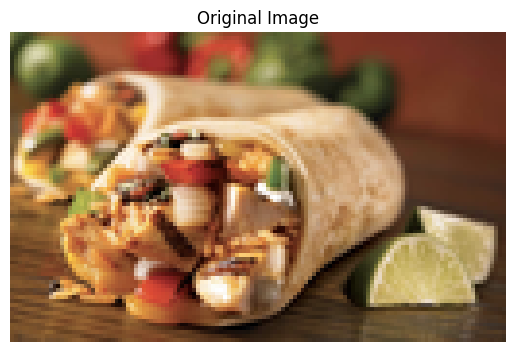

In [6]:
# Plotting Original Resolution image
plot_image(tf.squeeze(lr_image), title="Original Image")
save_image(tf.squeeze(lr_image), filename="Original Image")

### Load model

We will now download the model from the TensorFlow hub.

In [7]:
model = hub.load(SAVED_MODEL_PATH)

### Generate high-resolution image

The next step is to create the high-resolution image by passing the low-resolution image to the model.

In [8]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.766880


### Plotting the high-resolution image

Saved as High Resolution.jpg


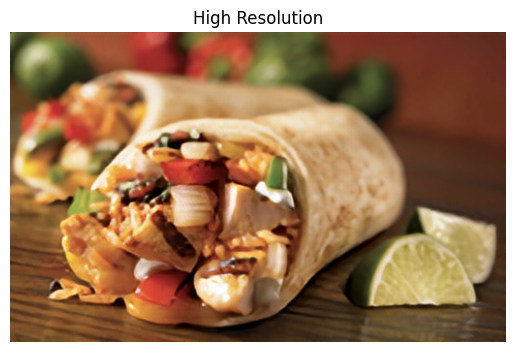

In [9]:
plot_image(fake_image, title="High Resolution")
save_image(fake_image, filename="High Resolution")

### Evaluate model

To evaluate the model we will take a high-resolution image, downsample it and enhance it using the model. Then we will compare the output with the original image to check how well the model performed.

#### Download test image

In [42]:
urllib.request.urlretrieve(TEST_IAMGE_URL, TEST_IMAGE_SAVE_PATH)

('test.png', <http.client.HTTPMessage at 0x14e11f2e0>)

#### Load test image

In [43]:
hr_test_image = preprocess_image(TEST_IMAGE_SAVE_PATH)
lr_test_image = downscale_image(tf.squeeze(hr_test_image))

/var/folders/tp/s9thqy9d2db4565h_3nk9d1r0000gn/T/ipykernel_49116/116091358.py:39: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC))


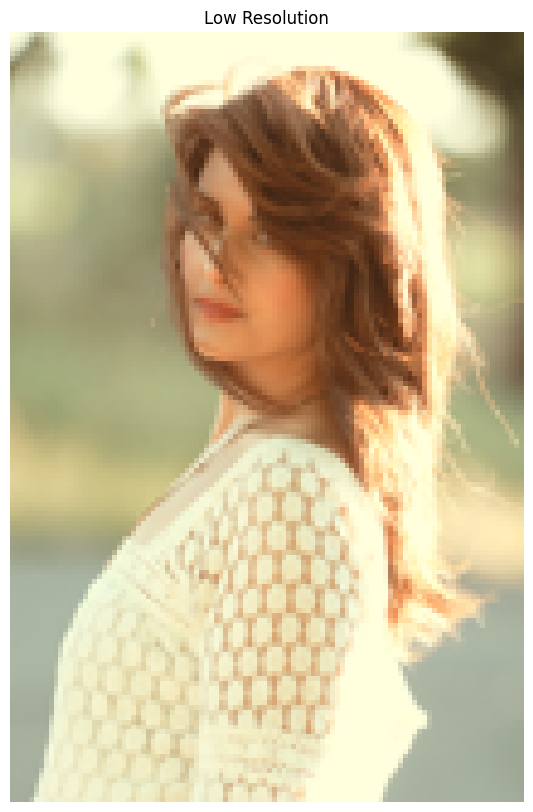

In [44]:
plot_image(tf.squeeze(lr_test_image), title="Low Resolution")

#### Generate high-resolution image

In [45]:
start = time.time()
fake_test_image = model(lr_test_image)
fake_test_image = tf.squeeze(fake_test_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.289338


#### Plotting the high-resolution image

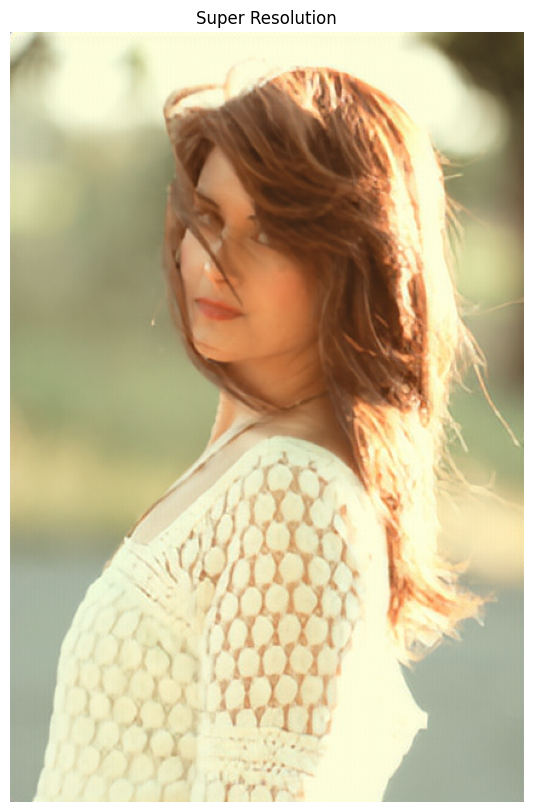

In [46]:
plot_image(fake_test_image, title="Super Resolution")

#### Comparing outputs side by side

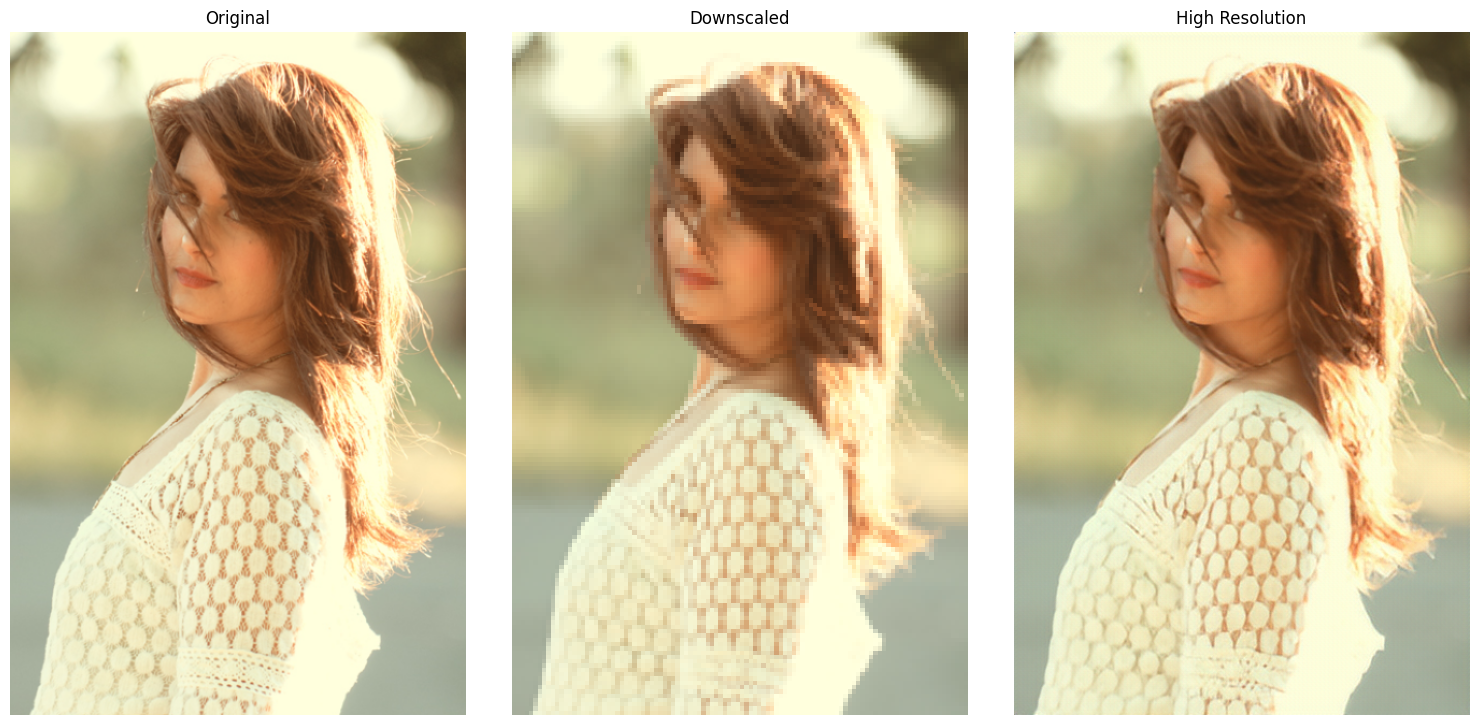

In [49]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_test_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_test_image), "Downscaled")
plt.subplot(133)
fig.tight_layout()
plot_image(fake_test_image, "High Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")

#### Calculating PSNR

The PSNR block computes the peak signal-to-noise ratio, in decibels, between two images. This ratio is used as a quality measurement between the original and a compressed image. The higher the value, the better the quality of compressed image.

In [48]:
psnr = tf.image.psnr(
    tf.clip_by_value(fake_test_image, 0, 255),
    tf.clip_by_value(hr_test_image, 0, 255), max_val=255)
print("PSNR: %f" % psnr)

PSNR: 31.046724


### Conclusion

We built an image enhancer using TensorFlow and Enhanced Super Resolution Generative Adversarial Network(ESRGAN). You can use this for preprocessing images in a computer vision application or to enhance the old images of your loved ones.
I love your feedback, please let me know what you think.